<a href="https://colab.research.google.com/github/unique-subedi/gene-expression/blob/main/Vinod_gene_expression_master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import os
import datetime
import time
import math
import numpy as np
from numpy import linalg as LA
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [2]:
!pip install pyreadr
import pyreadr
urllib.request.urlretrieve("https://raw.githubusercontent.com/unique-subedi/gene-expression/main/data/brain.rda", "brain.rda")
brain = pyreadr.read_r("brain.rda")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 363 kB 4.9 MB/s 


In [3]:
expression = pd.DataFrame(brain["expression"])
genes = pd.DataFrame(brain["genes"])
samples = pd.DataFrame(brain["samples"])

In [5]:
genes_Y_crom = genes[genes.chrom == "Y"].index
genes_bac_index = genes[genes.chrom.isnull()].index
mean_bac_exp = expression[genes_bac_index].max(axis=1)
print(mean_bac_exp)
expression_norm =  expression - mean_bac_exp.values[:, None]

01_a_D_f_2.CEL    14.394582
01_a_I_f_2.CEL    15.494106
01_a_M_f_1.CEL    12.856782
01_c_D_f_1.CEL    13.683484
01_c_I_f_2.CEL    15.494106
                    ...    
10_c_I_f_2.CEL    15.493637
10_c_M_f_1.CEL    12.665336
10_d_D_f_2.CEL    14.244014
10_d_I_f_2.CEL    15.493855
10_d_M_f_2.CEL    12.794010
Length: 84, dtype: float64


A.C. cortex
3
['Y', 'Y', 'X', '7', '3', '12', '11', '6', '7', '2']
Categories (39, object): ['1', '10', '10ak*', '10ptp*', ..., 'X', 'X Y', 'Y', 'na'] ['RPS4Y1', 'DDX3Y', 'PLP1', 'ACTB', 'MOBP', 'GAPDH', 'HBB', 'RPS12', 'ACTB', 'RPL31']
Categories (8783, object): ['AADAC', 'AAK1', 'AAMP', 'AANAT', ..., 'ZYX', 'ZZEF1', 'ZZZ3', 'psiTPTE22']

cerebellum
3
['Y', '11', '11', '16hba1', 'Y', 'X', '4', '18', '3', '17']
Categories (39, object): ['1', '10', '10ak*', '10ptp*', ..., 'X', 'X Y', 'Y', 'na'] ['RPS4Y1', 'HBB', 'HBB', NaN, 'DDX3Y', 'PLP1', 'SPP1', 'MBP', 'TF', 'GFAP']
Categories (8783, object): ['AADAC', 'AAK1', 'AAMP', 'AANAT', ..., 'ZYX', 'ZZEF1', 'ZZZ3', 'psiTPTE22']

D.L.P.F. cortex
5
['Y', 'Y', 'Y', 'Y', '11', '16hba1', '2', 'X', '1', '11']
Categories (39, object): ['1', '10', '10ak*', '10ptp*', ..., 'X', 'X Y', 'Y', 'na'] ['RPS4Y1', 'DDX3Y', 'USP9Y', 'KDM5D', 'HBB', NaN, 'GAD1', NaN, 'RGS4', 'HBB']
Categories (8783, object): ['AADAC', 'AAK1', 'AAMP', 'AANAT', ..., 'ZYX', 'ZZEF1',

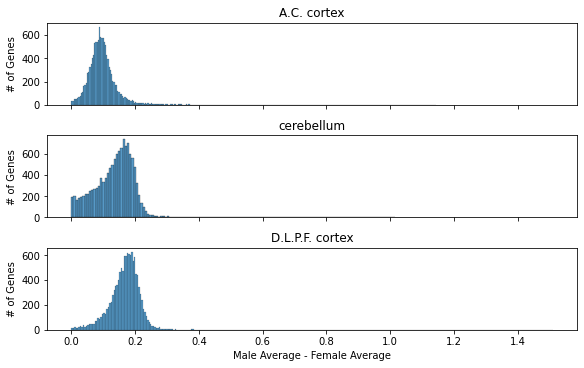

In [18]:
express_norm_samp = pd.concat([expression_norm, samples], axis=1)
fig, axs = plt.subplots(3, 1, figsize=(8, 5), constrained_layout=True, sharex='all')
express_samp_loc = express_norm_samp
c = 0
for tissue in express_samp_loc["region"].unique():
  print(tissue)
  df_male = express_samp_loc[(express_samp_loc.region == tissue) & (express_samp_loc.sex == "male")]
  df_female = express_samp_loc[(express_samp_loc.region == tissue) & (express_samp_loc.sex == "female")]

  male_mean = expression_norm.loc[df_male.index].mean()
  female_mean = expression_norm.loc[df_female.index].mean()

  diff = np.abs(male_mean - female_mean)
  sns.histplot(diff, ax = axs[c])
  axs[c].set_title(tissue)
  axs[c].set_xlabel("Male Average - Female Average")
  axs[c].set_ylabel("# of Genes")
  diff = diff.sort_values(ascending=False)
  top_10 = diff.iloc[:10]
  op_chrom = genes.loc[top_10.keys()].loc[:, 'chrom'].values
  op_genes = genes.loc[top_10.keys()].loc[:, 'sym'].values
  chrom_counter = Counter(op_chrom)
  count = np.sum([chrom_counter[key] for key, value in chrom_counter.items() if key in ["X", "Y", "X Y"]])
  print(count)
  print(op_chrom, op_genes)
  print("")
  c += 1



